In [3]:
# loading package
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns 
sns.set(font_scale=1.56)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

In [4]:
# loading data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test)

/var/folders/br/4p44s20n1dg064gmwckrvs_w0000gn/T/ipykernel_64914/1874471725.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_train.append(df_test)


In [5]:
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [6]:
# ignore warning
import warnings
warnings.filterwarnings("ignore")

,Sex,Survived
0,female,0.742
1,male,0.189


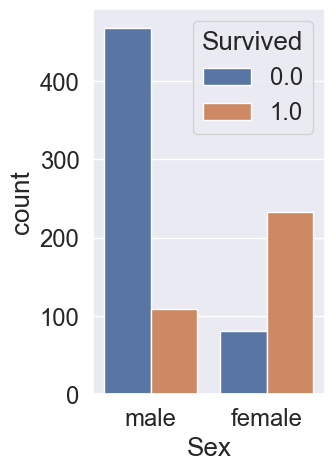

In [7]:
plt.figure(figsize=(3,5))
sns.countplot(x='Sex', hue='Survived', data=df_data)
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

我們可以預期到，頭等艙的乘客生存機率會比較高，不論是逃生設備，或是沈船訊息可能最先傳到頭等艙，鐵達尼號有3個艙等 : 1,2,3 (姑且稱為頭等艙、商務艙和經濟艙XD?)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


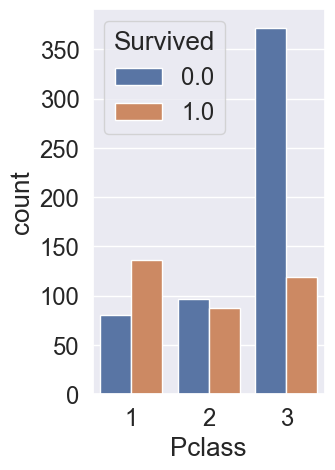

In [8]:
plt.figure(figsize=(3,5))
sns.countplot(x='Pclass', hue='Survived', data=df_data)
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

In [9]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [10]:
# split training set the testing set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [11]:
# Inputs set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']


In [12]:
# Show Baseline
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.73176


In [13]:
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

票價取log vs 艙等，其中黃色的盒子為存活下來的，綠色反之，中線為票價取log之後的中位數。
票價和艙等都是屬於彰顯乘客社會地位的一個特徵，同時也可以在EDA當中發現，買票價格較高的乘客，他們的生存機率也較高。
從表以及圖中我們都可以看出存活下來的乘客確實平均而言付出較高的票價，我們決定測試這個特徵，然而，測試之前，我們需要將票價切分成幾個區間，才不會讓模型overfit的太嚴重，

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

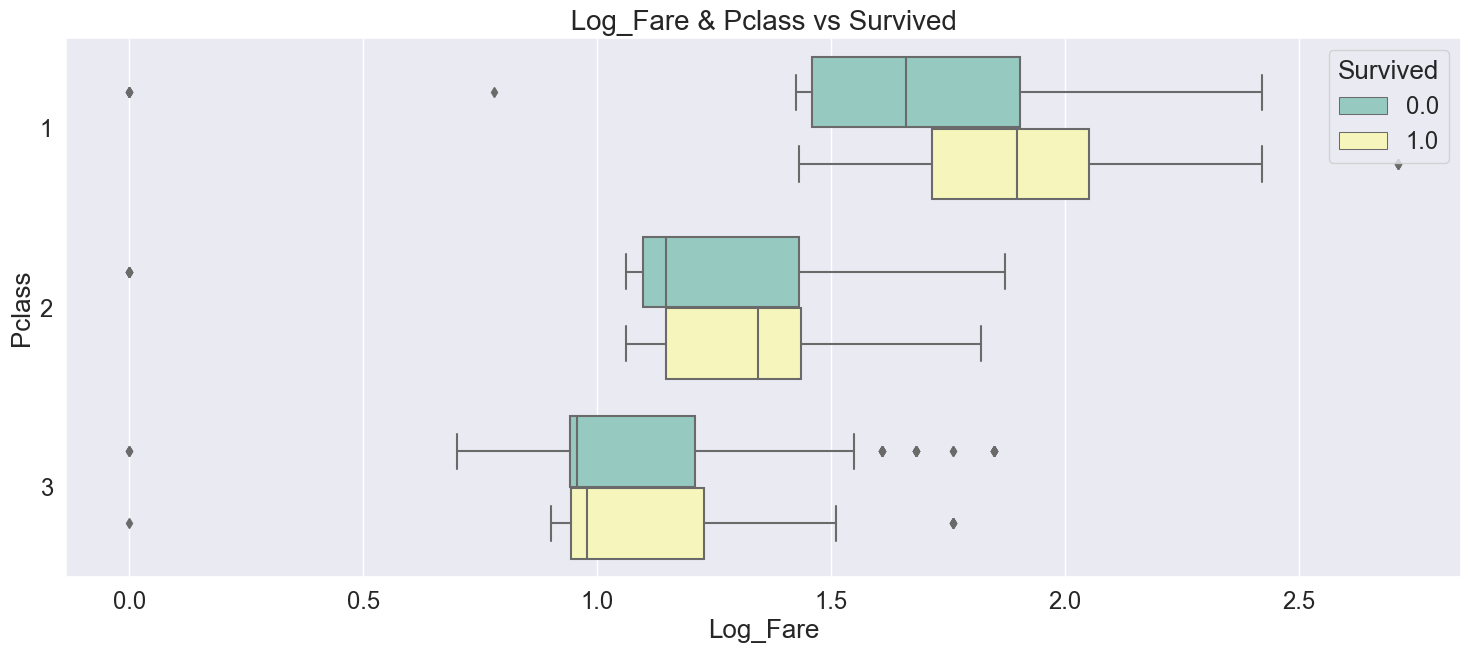

In [14]:
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


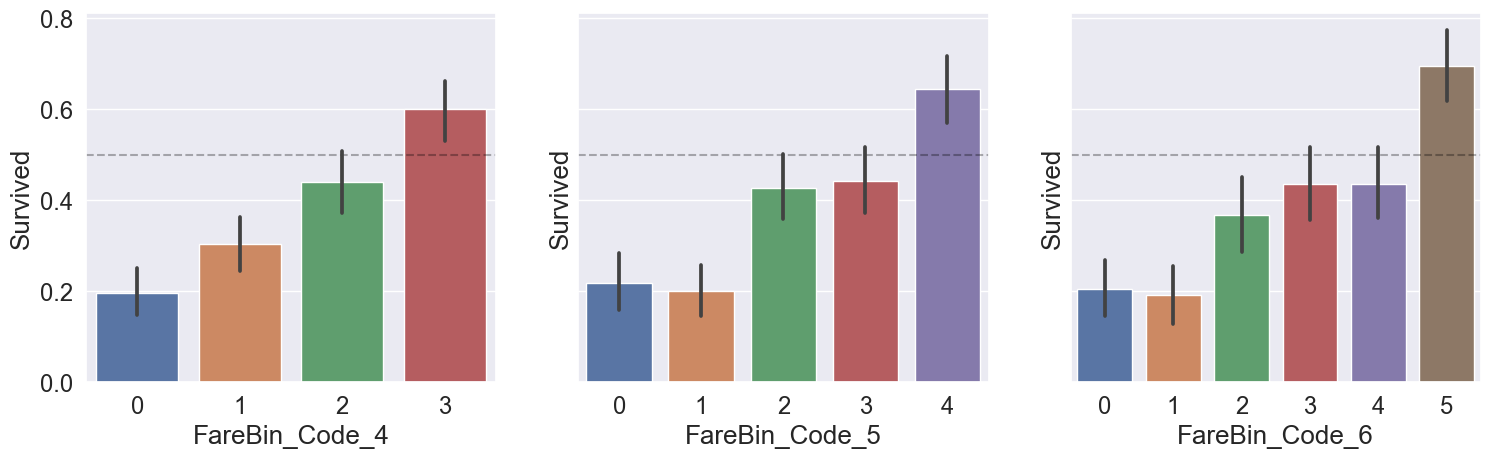

In [15]:
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# Making Bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', c='black', alpha=0.3)

# 使用 catplot 替代 factorplot
sns.barplot(x='FareBin_Code_4', y="Survived", data=df_data, ax=ax1)
sns.barplot(x='FareBin_Code_5', y="Survived", data=df_data, ax=ax2)
sns.barplot(x='FareBin_Code_6', y="Survived", data=df_data, ax=ax3)

# 显示图形
plt.show()

In [16]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [17]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f  '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033    LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


這個情況在Titanic這個資料集上很常見，我認為是某種過度的特徵工程所帶來的overfitting，畢竟特徵工程在數學上也可以想像成原始特徵的非線性轉換，僅僅是我們賦予了每一種特徵工程對應的意義，然後相信這樣做是有用的，最終都必須得在CV以及排行榜上測試

In [18]:
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

b4_pred = b4_Model.predict(X_Submit[b4])
b5_pred = b5_Model.predict(X_Submit[b5])
b6_pred = b6_Model.predict(X_Submit[b6])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b4_pred.astype(int)})
submit.to_csv("submit_b4.csv",index=False)
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b5_pred.astype(int)})
submit.to_csv("submit_b5.csv",index=False)
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b6_pred.astype(int)})
submit.to_csv("submit_b6.csv",index=False)

In [19]:
df_train['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [20]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [21]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [22]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [23]:
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [24]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [25]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


connect  : 0.79665

In [26]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

connect_pred = connect_Model.predict(X_Submit[connect])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":connect_pred.astype(int)})
submit.to_csv("submit_connect.csv",index=False)

從左圖我們可以明顯的看出年齡缺失值蠻大部分在3等艙，如果年齡真的是個重要特徵，則我們對3等艙的觀察就會失真，保守的作法是觀察1,2艙等中年齡對存活與否的影響。
右圖則顯示了缺失值對性別的分布，搭配著表格看的話，466位女性有78位缺失年齡(16.7%)，843位男性有185位缺失年齡(21.9%)，比例差了5%，男性缺失年齡稍微多一點，如果年齡對生存與否有影響的話，可能可以搭配男性藉此被區分出更多的生還者(例如男性小孩生還率有可能高於男性成人)

Sex      female  male   All
Has_Age                    
0            78   185   263
1           388   658  1046
All         466   843  1309


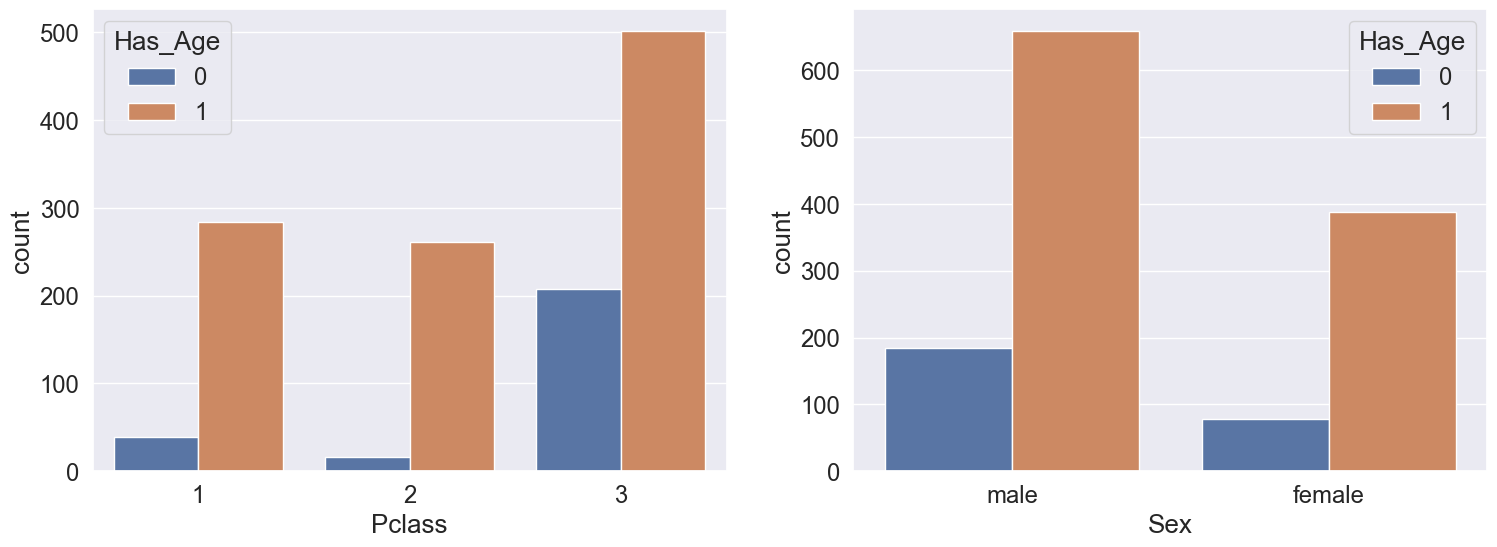

In [27]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x: 0 if x else 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 6))

# Countplot for Pclass and Has_Age
sns.countplot(x='Pclass', hue='Has_Age', data=df_data, ax=ax1)

# Countplot for Sex and Has_Age
sns.countplot(x='Sex', hue='Has_Age', data=df_data, ax=ax2)

# Crosstab for Has_Age and Sex
crosstab_result = pd.crosstab(df_data['Has_Age'], df_data['Sex'], margins=True).round(3)
print(crosstab_result)


左邊藍色的部分多出了一塊，也就是這部分生存率較高的，約<16歲，表示青少年以下(包含小孩)會有較高的生存率，同時，其餘部分也顯示出了，若>16歲，基本上年齡不算是一個顯著的特徵來判定是否生還，而70~80歲的這個區間，由於樣本數太少，因此不列入採計。綜合上述3張圖的討論，我認為找出那些<16歲的缺失值是重要的，這會影響預測，而>16歲的部分則不採用，否則只是擬合了噪聲，因此年齡這個特徵可以抽取出<16歲及>16歲做為一個2元特徵

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

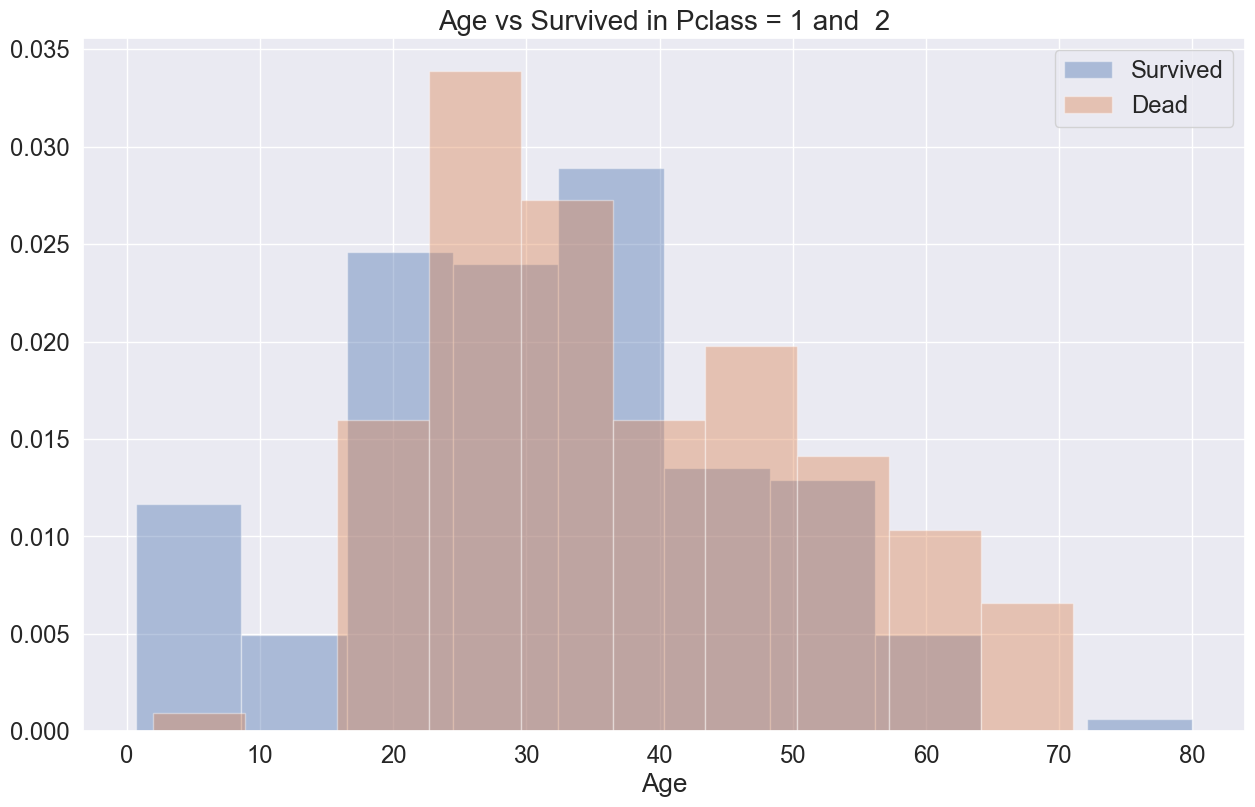

In [28]:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

In [29]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [30]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [31]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [32]:
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


In [35]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

minor_pred = minor_Model.predict(X_Submit[minor])
print (minor_pred)
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":minor_pred.astype(int)})
submit.to_csv("submit_minor.csv",index=False)

[0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.

In [34]:
def Missing_Counts( Data, NoMissing=True ) : 
    missing = Data.isnull().sum()  
    
    if NoMissing==False :
        missing = missing[ missing>0 ]
        
    missing.sort_values( ascending=False, inplace=True )  
    Missing_Count = pd.DataFrame( { 'Column Name':missing.index, 'Missing Count':missing.values } ) 
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['Missing Count'].apply( lambda x: '{:.2%}'.format(x/Data.shape[0] ))
    return  Missing_Count

Missing_Counts(train)

NameError: name 'train' is not defined

In [ ]:
def Missing_Counts( Data, NoMissing=True ) : 
    missing = Data.isnull().sum()  
    
    if NoMissing==False :
        missing = missing[ missing>0 ]
        
    missing.sort_values( ascending=False, inplace=True )  
    Missing_Count = pd.DataFrame( { 'Column Name':missing.index, 'Missing Count':missing.values } ) 
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['Missing Count'].apply( lambda x: '{:.2%}'.format(x/Data.shape[0] ))
    return  Missing_Count

Missing_Counts(test)

,Column Name,Missing Count,Percentage(%)
0,Age,86,20.57%
1,Fare,1,0.24%
2,Pclass,0,0.00%
3,Name,0,0.00%
4,Sex,0,0.00%
5,SibSp,0,0.00%
6,Parch,0,0.00%
7,Ticket,0,0.00%
8,Cabin,0,0.00%
9,Embarked,0,0.00%


In [ ]:
train = train.dropna( subset = ["Embarked"] ) #subset參數裡面放要刪除缺失值的特徵

In [ ]:
train['Cabin'].unique()

array(['No_Cabin', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'C83', 'F33', 'F G73',
       'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69',
       'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32',
       'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87',
       'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49',
       'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66',
       'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128',
       'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
      

完全隨機缺失的資料不太好進行補值，假如刪除的話也會遺失過多資訊，
因此自行給定一個值"No_Cabin"代表缺失船艙號碼的乘客來進行補植。

In [ ]:
train['Cabin']=train['Cabin'].fillna("No_Cabin") 
test['Cabin']=test['Cabin'].fillna("No_Cabin") 

<Axes: xlabel='Age', ylabel='Density'>

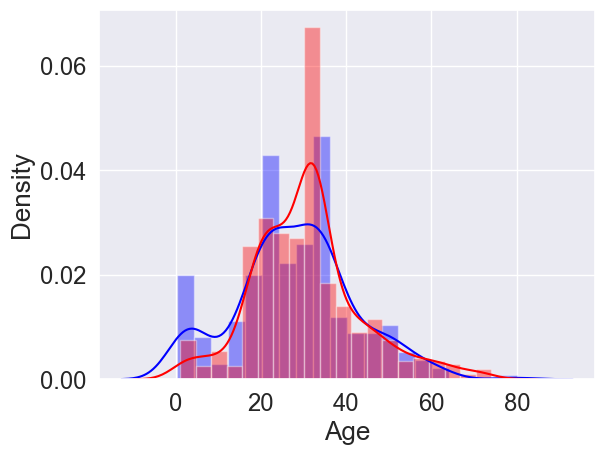

In [ ]:
import seaborn as sns
index_survived = (train["Age"].isnull()==False)&(train["Survived"]==1)
index_died = (train["Age"].isnull()==False)&(train["Survived"]==0)

sns.distplot( train.loc[index_survived ,'Age'], bins=20, color='blue', label='Survived' )
sns.distplot( train.loc[index_died ,'Age'], bins=20, color='red', label='Survived' )

In [ ]:
compare = ['Sex_Code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

KeyboardInterrupt: 

In [ ]:
test['Title'] = test.Name.str.split(', ', expand=True)[1]
test['Title'] = test.Title.str.split('.', expand=True)[0]
test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [ ]:
Age_Mean = train[['Title','Age']].groupby( by=['Title'] ).mean()

Age_Mean.columns = ['Age_Mean']
Age_Mean.reset_index( inplace=True )

display( Age_Mean )

,Title,Age_Mean
0,Capt,70.000000
1,Col,58.000000
2,Don,40.000000
3,Dr,42.000000
4,Jonkheer,38.000000
5,Lady,48.000000
6,Major,48.500000
7,Master,4.574167
8,Miss,21.662069
9,Mlle,24.000000


In [ ]:
Age_Mean = test[['Title','Age']].groupby( by=['Title'] ).mean()

Age_Mean.columns = ['Age_Mean']
Age_Mean.reset_index( inplace=True )

display( Age_Mean )

,Title,Age_Mean
0,Col,50.000000
1,Dona,39.000000
2,Dr,53.000000
3,Master,7.406471
4,Miss,21.774844
5,Mr,32.000000
6,Mrs,38.903226
7,Ms,NaN
8,Rev,35.500000


In [ ]:
train = train.reset_index() #重整index
train["Age"].isnull()
for i in range(len(train["Age"].isnull())):
    if train["Age"].isnull()[i]==True:
        for j in range(len(Age_Mean.Title)):
            if train["Title"][i]==Age_Mean.Title[j]:
                train["Age"][i]=Age_Mean.Age_Mean[j]

/var/folders/br/4p44s20n1dg064gmwckrvs_w0000gn/T/ipykernel_46028/921591786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Age"][i]=Age_Mean.Age_Mean[j]


In [ ]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [ ]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [ ]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [ ]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [ ]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [ ]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [ ]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


In [ ]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

connect_pred = connect_Model.predict(X_Submit[connect])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":connect_pred.astype(int)})
submit.to_csv("submit_connect.csv",index=False)

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


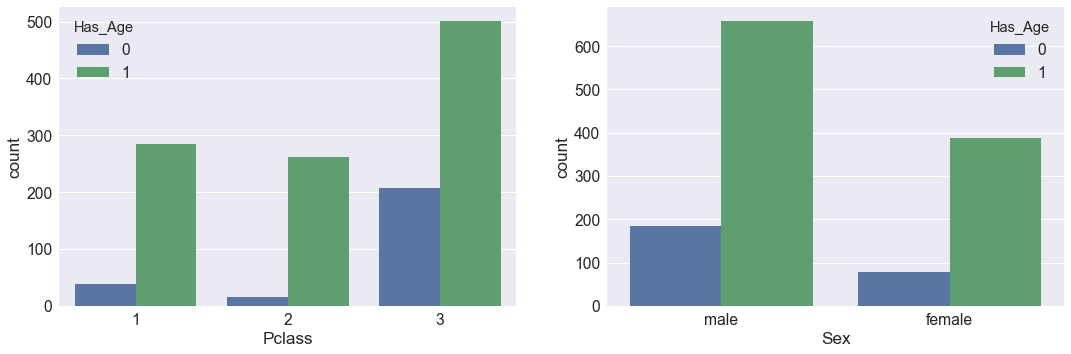

In [ ]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

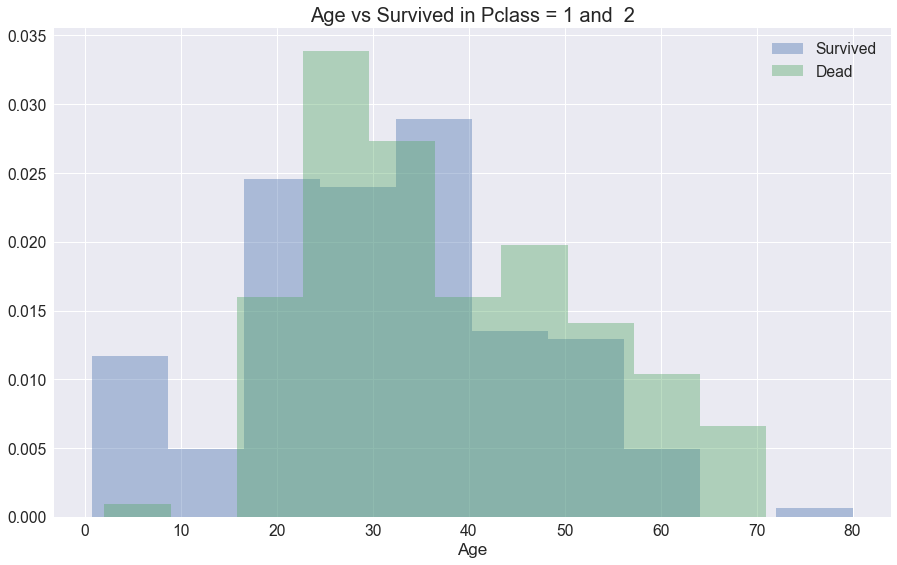

In [ ]:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

In [ ]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [ ]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [ ]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [ ]:
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


In [ ]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
print ( minor_pred )
minor_pred = minor_Model.predict(X_Submit[minor])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":minor_pred.astype(int)})
submit.to_csv("submit_minor.csv",index=False)

NameError: name 'df_test' is not defined

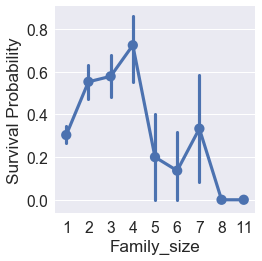

In [ ]:
g = sns.factorplot(x='Family_size', y='Survived',data=df_data)
g = g.set_ylabels("Survival Probability")

In [ ]:
# cut into 3 class
df_data['L_Family'] = df_data['Family_size'].apply(lambda x: 0 if x<= 4 else 1).astype(int)
df_data.loc[ df_data['Family_size'] == 1, 'FamilyClass'] = 0
df_data.loc[ (df_data['Family_size'] <= 4) & (df_data['Family_size'] > 1), 'FamilyClass'] = 1
df_data.loc[ df_data['Family_size'] >= 5, 'FamilyClass'] = 2
df_data['FamilyClass'] = df_data['FamilyClass'].astype(int) 
df_data[['FamilyClass','Survived']].groupby(['FamilyClass']).mean()

,Survived
FamilyClass,
0,0.303538
1,0.578767
2,0.161290


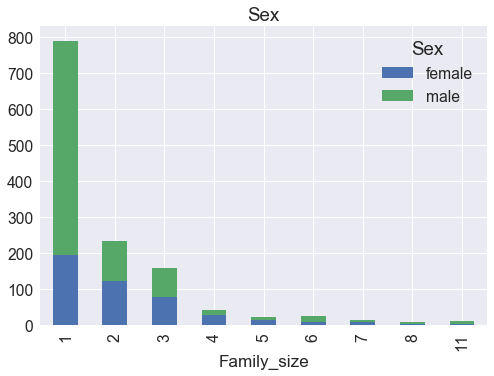

In [ ]:
# display(pd.crosstab(df_data['Sex'],df_data['Family_size'],margins=True))
# visualize
pd.crosstab(df_data['Family_size'],df_data['Sex']).plot(kind='bar',stacked=True,title="Sex")

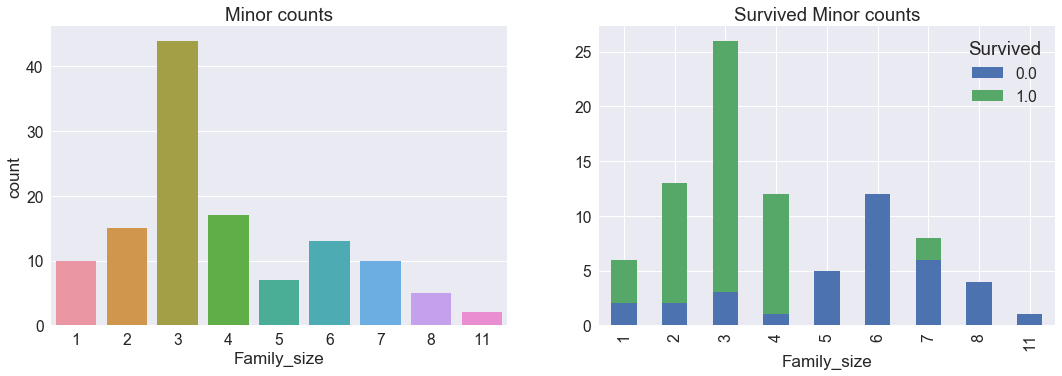

In [ ]:
Minor_mask = (df_data.Ti_Minor == 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
sns.countplot(df_data[Minor_mask]['Family_size'],ax=ax1)
ax1.set_title("Minor counts")
pd.crosstab(df_data[Minor_mask]['Family_size'],df_data[Minor_mask]['Survived'])\
.plot(kind='bar',stacked=True,title="Survived Minor counts",ax=ax2)